# Analytic Center

The **analytic center** of a [convex polytope](https://en.wikipedia.org/wiki/convex_polytope) defined by the set of linear inequalities $a_i^T x \leq b_i$ is given by

$$
\text{minimize} \quad -\sum_{i=1}^{m} \log(b_i - a_i^T x) 
$$

The objective function is sometimes called a log-barrier when it is used to enforce linear inequality constraints. Note that the analytic center is undefined if the polytope ${\cal P} = \{x \mid a_i^T x \leq b_i \text{ for } i = 1, \ldots, m\}$ has empty interior.

In [1]:
import torch
print("Torch version {}".format(torch.__version__))
print(torch.cuda.get_device_name() if torch.cuda.is_available() else "No CUDA")

torch.manual_seed(22)

import sys
sys.path.append("../")

Torch version 2.1.0
No CUDA


# Finding the Analytic Center

We can find the analytic center using Netwon's method starting from a feasible point $x_0 \in {\cal P} = \{x \mid Ax \preceq b\}$ as

$$
x \gets x - (\nabla^2 \phi)^{-1} \nabla \phi(x)
$$

where

$$
\begin{align*}
    \phi(x) &= -\sum_{i=1}^{m} \log(b_i - a_i^T x)
    \\
    \nabla \phi(x) &= A^T (1 \oslash (b - Ax))
    \\
    \nabla^2 \phi(x) &= A^T \text{diag}(b - Ax)^{-2} A
\end{align*}
$$

are the log-barrier function, gradient and Hessian, respectively.

In [2]:
def phi(A, b, x):
    """Compute the log-barrier function for a set of linear inequalities Ax <= b. Also returns the residuals, r = b - Ax."""
    r = b - A.matmul(x)
    return -1.0 * torch.log(r).sum() if torch.all(r > 0.0) else None, r

def dphi(A, b, x, r=None):
    """Compute the gradient of the log-barrier function."""
    if r is None:
        r = b - A.matmul(x)
    inv_r = torch.where(r > 1.0e-6, 1.0 / r, 1.0e6)
    return A.t().matmul(inv_r)

def ddphi(A, b, x, r=None):
    """Compute the Hessian of the log-barrier function."""
    if r is None:
        r = b - A.matmul(x)
    inv_r = torch.where(r > 1.0e-6, 1.0 / r, 1.0e6)
    A_inv_r = A * inv_r
    return A_inv_r.t().matmul(A_inv_r)

def newton(x0, fcn, grad, hess, max_iters=100, tol=1.0-6, alpha=0.5, beta=0.9):
    """Generic Newton method."""

    x = x0.clone()
    for i in range(max_iters):
        # compute function value, gradient and Hessian
        f, g, H = fcn(x), grad(x), hess(x)

        # compute Netwon's method
        try:
            dx = torch.linalg.solve(H, g)
        except RuntimeError:
            dx = torch.linalg.lstsq(H, g.unsqueeze(1)).solution.squeeze()

        # backtracking line search
        t = 1.0
        for _ in range(10):
            x_t = x - t * dx
            f_t = fcn(x_t)
            # check feasibility
            if f_t is not None:
                # check stopping condition
                if f_t <= f - alpha * t * g.t().matmul(dx):
                    break
            t *= beta

        # update and check for convergence
        x = x_t
        if torch.norm(dx) < tol:
            break

    return x

# 2D Example

Let's plot a 2D example.

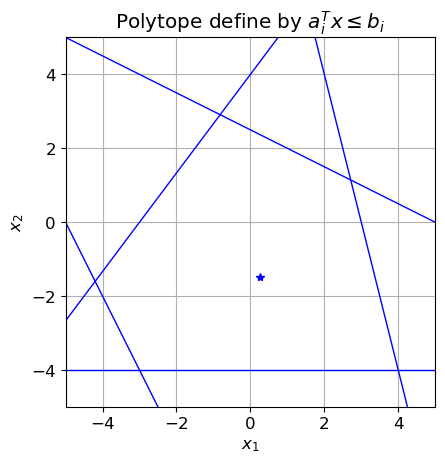

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

def plot_polytope(A, b, xlim=(-5, 5), ylim=(-5, 5), ax=None, ls='b-'):
    """Plots the boundaries of the 2D polytope defined by Ax <= b."""
    M, N = A.shape
    assert (N == 2) and (b.shape == (M, 1) or b.shape == (M,))
    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    fig = ax.figure

    x_vals = np.linspace(xlim[0], xlim[1], 100)
    for i in range(M):
        if abs(A[i, 1]) < 1.0e-9:
            ax.plot([b[i] / A[i, 0], b[i] / A[i, 0]], ylim, ls, lw=1)
        else:
            ax.plot(x_vals, (b[i] - A[i, 0] * x_vals) / A[i, 1], ls, lw=1)

    ax.set_xlim(xlim), ax.set_ylim(ylim)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel(r'$x_1$'), ax.set_ylabel(r'$x_2$')
    ax.set_title(r"Polytope define by $a_i^T x \leq b_i$")
    return fig, ax

# example polytopes
A_init = torch.tensor([[1, 2], [1, 0.25], [0, -1], [-1, -0.5], [-1, 0.75]], dtype=torch.float)
b_init = torch.tensor([[5], [3], [4], [5], [3]], dtype=torch.float)

fig, ax = plot_polytope(A_init, b_init, ls='b-')
x0 = torch.tensor([[0.0], [0.0]])
x_ac = newton(x0, lambda x: phi(A_init, b_init, x)[0], lambda x: dphi(A_init, b_init, x), lambda x: ddphi(A_init, b_init, x))
ax.plot(x_ac[0], x_ac[1], 'b*')
ax.grid(True)
plt.show()


### Declarative Node

Let's write a deep declarative node for computing the analytic center. **WARNING:** The code here is for illustrative purposes. It makes several simplifying assumptions. First, it assumes that zero is inside the polytope (feasible set). If this is not the case then a Stage I method will need to be used to find a feasible starting point. Second, the code is not designed for batch processing.

In [4]:
class AnalyticCenterFcn(torch.autograd.Function):
    """PyTorch autograd function for analytic centering problem. Assumes that zero is always a feasible starting point. Non-batched."""

    tol = 1.0e-9 # tolerance

    @staticmethod
    def forward(ctx, A, b):
        M, N = A.shape
        assert b.shape == (M, 1)

        with torch.no_grad():
            x0 = torch.zeros((N, 1), dtype=A.dtype, device=A.device)
            x = newton(x0, lambda x: phi(A, b, x)[0], lambda x: dphi(A, b, x), lambda x: ddphi(A, b, x))

        ctx.save_for_backward(A, b, x)
        return x

    @staticmethod
    def backward(ctx, dLdx):
        A, b, x = ctx.saved_tensors
        M, N = dLdx.shape

        # explicitly complute v^T H^{-1}
        H = ddphi(A, b, x)
        try:
            vH = torch.linalg.solve(H, dLdx)
        except RuntimeError:
            vH = torch.linalg.lstsq(H, dLdx.unsqueeze(1)).solution.squeeze()

        # implicitly compute dLdA and dLdb
        A_var = A.detach().requires_grad_(True)
        b_var = b.detach().requires_grad_(True)
        x_const = x.detach().requires_grad_(False)

        with torch.enable_grad():
            r = b_var - A_var.matmul(x_const)
            inv_r = torch.where(r > 1.0e-6, 1.0 / r, 1.0e6)
            g = -1.0 * A.t().matmul(inv_r)
        dLdA, dLdb = torch.autograd.grad(outputs=g, inputs=(A_var, b_var), grad_outputs=vH, retain_graph=False)
        
        return dLdA, dLdb 

### Testing

We test our code on the following bi-level optimisation problem,

$$
\begin{align*}
	\begin{array}{ll}
		\text{minimize} & \frac{1}{2} \|x^\star - x^{\text{target}}\|_2^2 \\
		\text{subject to} & x^\star = \textrm{argmin}_{x} \; -\sum_{i=1}^{m} \log(b_i - a_i^T x) 
	\end{array}
\end{align*}
$$

which finds the parameters $A$ and $b$ of a polytope ${\cal P} = \{x \mid Ax \preceq b\}$ with given analytic center $x^{\text{target}}$.

We run two versions of the optimizer: one that updates both $A$ and $b$ (red) and the other that updates only $b$ (green).

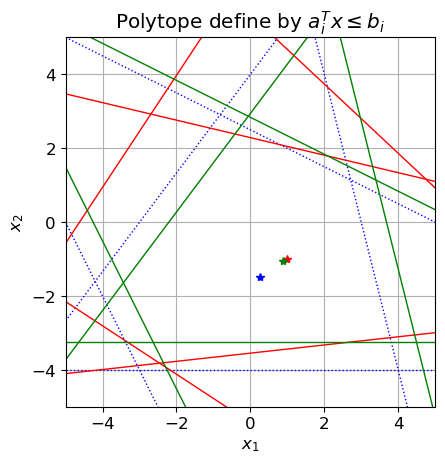

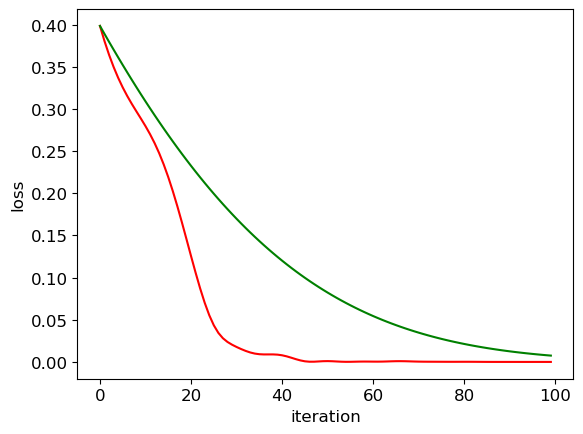

In [5]:
fcn = AnalyticCenterFcn.apply
theta = [torch.nn.Parameter(A_init.clone()), torch.nn.Parameter(b_init.clone())]
optimizer = torch.optim.AdamW(theta, lr=1.0e-2)
x_target = torch.tensor([[1.0], [-1.0]])

# optimize both A and b
loss_trace = [None for i in range(100)]
for iter in range(len(loss_trace)):
    x = fcn(theta[0], theta[1])
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(x, x_target)
    loss_trace[iter] = loss.item()
    loss.backward()
    optimizer.step()

# optimize just b
theta2 = [torch.nn.Parameter(b_init.clone())]
optimizer = torch.optim.AdamW(theta2, lr=1.0e-2)

loss_trace2 = [None for i in range(100)]
for iter in range(len(loss_trace)):
    x2 = fcn(A_init, theta2[0])
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(x2, x_target)
    loss_trace2[iter] = loss.item()
    loss.backward()
    optimizer.step()

# plots
fig, ax = plot_polytope(A_init, b_init, ls='b:')
ax.plot(x_ac[0], x_ac[1], 'b*')

plot_polytope(theta[0].detach().numpy(), theta[1].detach().numpy(), ax=ax, ls='r-')
ax.plot(x.detach().numpy()[0], x.detach().numpy()[1], 'r*')

plot_polytope(A_init.numpy(), theta2[0].detach().numpy(), ax=ax, ls='g-')
ax.plot(x2.detach().numpy()[0], x2.detach().numpy()[1], 'g*')
ax.grid(True)


plt.figure()
plt.plot(loss_trace, 'r-')
plt.plot(loss_trace2, 'g-')
plt.ylabel('loss'); plt.xlabel('iteration')
plt.show()
